Following analysis is done on prediction review score:


1.   Plot the distribution and analysis of the mean difference between predicted and actual ratings for each user and product
2.   Anomaly Detection
3.   Analysis of discrepancy in bias present in review text and review score

Note: When using a different dataset, change data location accordingly at all places

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sqlite3
import csv
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import numpy as np
import sys
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error

In [ ]:
test_data = pd.read_csv('drive/My Drive/ubr/ground_truth/7_test_data_biased.csv')

In [ ]:
user_dict = np.load("drive/My Drive/ubr/ground_truth/user_dict.npy",allow_pickle=True).item()
item_dict = np.load("drive/My Drive/ubr/ground_truth/item_dict.npy",allow_pickle=True).item()

# Plot the distribution and analysis of the mean difference between predicted and actual ratings for each user and product

In [ ]:
test_data['difference'] =  test_data['Biased_Score'] - test_data['Score']

In [ ]:
test_data

,ProductId,UserId,Summary,Text,Score,Unbiased_Score,Biased_Score,difference
0,B000652M6Y,AFXRO7K3ZZ0PX,b' best ever so far',b' thi be the best stylu ever $ i haven t have...,5.0,3.976114,3.993860,-1.006140
1,B005LFT3GG,A37CEYB95LK6R6,b' wa star',b' wa star $ i test the gbsandisk extrem pro g...,4.0,4.917229,4.667948,0.667948
2,B0097CZHAU,A26X7W5UM5QFT4,b' no good than other fairli basic screen save...,b' i do sever review thi even and all but thi ...,3.0,3.596357,3.714829,0.714829
3,B000A0UHXU,A3GTTWTYAEZUAG,b' fantast valu',b' i wa skeptic at first becaus of the low pri...,4.0,4.600000,4.600000,0.600000
4,B007KEZMX4,A21W2EZ9LA25ST,b' live without it befor',b' my first experi with a roku wa recommend it...,2.0,4.302322,4.269116,2.269116
...,...,...,...,...,...,...,...,...
75520,B002J9HBIO,AY687CJMS8J6G,b' right size right protect right price',b' after lug around my laptop use a fulli pad ...,5.0,4.361977,4.309171,-0.690829
75521,B005H3Q57M,A2DB3W4GWFLJIA,b' great cord',b' work good and ha last long than the one tha...,5.0,3.689890,3.695913,-1.304087
75522,B00264GKVQ,AKFOHJ9R66KUN,b' it s expens but work great on the treadmil',b' you definit have to calibr it but it doe it...,4.0,4.581674,4.541593,0.541593
75523,B00AWKC0EC,ACMXHJV1KCOSV,b' interfac be a lot like the p',b' when it turn on it ll sometim caus a pop or...,3.0,3.586580,3.582997,0.582997


## Calculation of mean difference value for each user and product

### Product

In [ ]:
item_unique = test_data.ProductId.unique()
print(item_unique.shape)
print(item_unique)

(18914,)
['B000652M6Y' 'B005LFT3GG' 'B0097CZHAU' ... 'B00C8OCEC8' 'B003JV3XZ6'
 'B002GM5GKO']


In [ ]:
#converting to a dataframe
item_diff = pd.DataFrame({'ProductId': item_unique})

In [ ]:
item_d = []
for item in range(len(item_unique)):
  test_item = test_data[test_data['ProductId'] == item_unique[item]]
  val = test_item['difference'].mean()
  item_d.append(val)

In [ ]:
item_diff['difference'] = item_d
item_diff

,ProductId,difference
0,B000652M6Y,-0.136928
1,B005LFT3GG,-0.020234
2,B0097CZHAU,0.410787
3,B000A0UHXU,0.017283
4,B007KEZMX4,-0.135827
...,...,...
18909,B0016A0RLA,-0.901031
18910,B00005T3W5,-0.341854
18911,B00C8OCEC8,-0.653732
18912,B003JV3XZ6,1.146154


### User

In [ ]:
user_unique = test_data.UserId.unique()
print(user_unique.shape)
print(user_unique)

(17486,)
['AFXRO7K3ZZ0PX' 'A37CEYB95LK6R6' 'A26X7W5UM5QFT4' ... 'A39WT90K0MDJD9'
 'AZKDLBTHU2BVZ' 'A3A5XNAM3ZW7Z6']


In [ ]:
user_diff = pd.DataFrame({'UserId': user_unique})

In [ ]:
user_d = []
for user in range(len(user_unique)):
  test_user = test_data[test_data['UserId'] == user_unique[user]]
  val = test_user['difference'].mean()
  user_d.append(val)

In [ ]:
user_diff['difference'] = user_d
user_diff

,UserId,difference
0,AFXRO7K3ZZ0PX,0.044541
1,A37CEYB95LK6R6,0.315935
2,A26X7W5UM5QFT4,0.104634
3,A3GTTWTYAEZUAG,1.082661
4,A21W2EZ9LA25ST,1.357407
...,...,...
17481,A1Y6G2QYH4AZNZ,0.066059
17482,A1FP2LA6M2OJX0,0.224385
17483,A39WT90K0MDJD9,0.888254
17484,AZKDLBTHU2BVZ,-0.618294


In [ ]:
item_diff.to_csv('drive/My Drive/ubr/ground_truth/bias_item_diff_mean.csv', index=False)
user_diff.to_csv('drive/My Drive/ubr/ground_truth/bias_user_diff_mean.csv', index=False)

## Frequency distribution of mean difference values



### Product

Text(0.5, 1.0, 'Item biased-score')

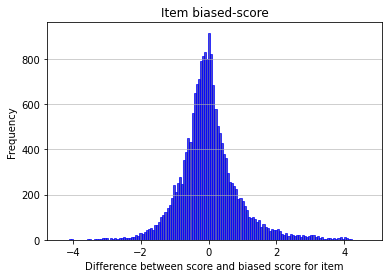

In [ ]:
n, bins, patches = plt.hist(x=item_diff['difference'], bins='auto', color='#0504aa',
                            alpha=0.7, edgecolor='blue')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Difference between score and biased score for item')
plt.ylabel('Frequency')
plt.title('Item biased-score')

### User

Text(0.5, 1.0, 'User score-biased')

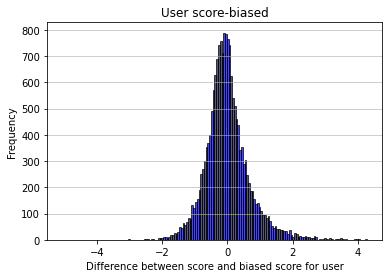

In [ ]:
n, bins, patches = plt.hist(x=user_diff['difference'], bins='auto', color='#0504aa',
                            alpha=0.7, edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Difference between score and biased score for user')
plt.ylabel('Frequency')
plt.title('User score-biased')

## Calculation of the number of users and products with certain average error (difference in predicted and actual review score)

### Error between -0.2 and 0.2

In [ ]:
bias_item_0d2 = item_diff[(item_diff['difference'] >= -0.2) & (item_diff['difference'] <= 0.2)]
bias_item_0d2 = bias_item_0d2.reset_index()
bias_item_0d2

,index,ProductId,difference
0,0,B000652M6Y,-0.136928
1,1,B005LFT3GG,-0.020234
2,3,B000A0UHXU,0.017283
3,4,B007KEZMX4,-0.135827
4,5,B00DQZRKY0,-0.150716
...,...,...,...
5170,18868,B0002J2EPI,-0.056383
5171,18875,B00001ZT4H,0.154885
5172,18876,B003XMAD0Y,-0.033834
5173,18887,B004JWPI9S,-0.152523


In [ ]:
bias_user_0d2 = user_diff[(user_diff['difference'] >= -0.2) & (user_diff['difference'] <= 0.2)]
bias_user_0d2 = bias_user_0d2.reset_index()
bias_user_0d2

,index,UserId,difference
0,0,AFXRO7K3ZZ0PX,0.044541
1,2,A26X7W5UM5QFT4,0.104634
2,8,A4EBYIKOMYFF9,0.013961
3,9,A3LH77PBDFEO3F,-0.196113
4,10,A1X4VWM6177NO0,-0.074293
...,...,...,...
5247,17468,A2H5YV3L760BF5,-0.076689
5248,17471,A2XHUR8JIYJ06B,0.113241
5249,17478,A3RLW85H7EYZR5,0.016660
5250,17481,A1Y6G2QYH4AZNZ,0.066059


### Error between -0.5 and 0.5

In [ ]:
bias_item_0d5 = item_diff[(item_diff['difference'] >= -0.5) & (item_diff['difference'] <= 0.5)]
bias_item_0d5 = bias_item_0d5.reset_index()
bias_item_0d5

,index,ProductId,difference
0,0,B000652M6Y,-0.136928
1,1,B005LFT3GG,-0.020234
2,2,B0097CZHAU,0.410787
3,3,B000A0UHXU,0.017283
4,4,B007KEZMX4,-0.135827
...,...,...,...
10702,18889,B0096YOQE2,0.498782
10703,18894,B003BEDRJI,-0.083333
10704,18899,B000B753CC,-0.324029
10705,18904,B009YCTO6Q,-0.267203


In [ ]:
bias_user_0d5 = user_diff[(user_diff['difference'] >= -0.5) & (user_diff['difference'] <= 0.5 )]
bias_user_0d5 = bias_user_0d5.reset_index()
bias_user_0d5

,index,UserId,difference
0,0,AFXRO7K3ZZ0PX,0.044541
1,1,A37CEYB95LK6R6,0.315935
2,2,A26X7W5UM5QFT4,0.104634
3,5,AQLL2R1PPR46X,0.246131
4,6,A3866HDI6HMH53,0.313194
...,...,...,...
11052,17472,A2G2R6ATW30D28,-0.305687
11053,17478,A3RLW85H7EYZR5,0.016660
11054,17481,A1Y6G2QYH4AZNZ,0.066059
11055,17482,A1FP2LA6M2OJX0,0.224385


### Error between -1.0 and 1.0

In [ ]:
bias_item_1 = item_diff[(item_diff['difference'] >= -1.0) & (item_diff['difference'] <= 1.0)]
bias_item_1 = bias_item_1.reset_index()
bias_item_1

,index,ProductId,difference
0,0,B000652M6Y,-0.136928
1,1,B005LFT3GG,-0.020234
2,2,B0097CZHAU,0.410787
3,3,B000A0UHXU,0.017283
4,4,B007KEZMX4,-0.135827
...,...,...,...
15324,18907,B004IMEN7C,-0.782583
15325,18909,B0016A0RLA,-0.901031
15326,18910,B00005T3W5,-0.341854
15327,18911,B00C8OCEC8,-0.653732


In [ ]:
bias_user_1 = user_diff[(user_diff['difference'] >= -1.0) & (user_diff['difference'] <= 1.0 )]
bias_user_1 = bias_user_1.reset_index()
bias_user_1

,index,UserId,difference
0,0,AFXRO7K3ZZ0PX,0.044541
1,1,A37CEYB95LK6R6,0.315935
2,2,A26X7W5UM5QFT4,0.104634
3,5,AQLL2R1PPR46X,0.246131
4,6,A3866HDI6HMH53,0.313194
...,...,...,...
15348,17481,A1Y6G2QYH4AZNZ,0.066059
15349,17482,A1FP2LA6M2OJX0,0.224385
15350,17483,A39WT90K0MDJD9,0.888254
15351,17484,AZKDLBTHU2BVZ,-0.618294


### Error greater than absolute value of 2

In [ ]:
high_bias_item = item_diff[(item_diff['difference'] >= 2) | (item_diff['difference'] <= -2)]
high_bias_item = high_bias_item.reset_index()
high_bias_item

,index,ProductId,difference
0,239,B003EE8OL6,3.264515
1,279,B001KEBR0C,-2.060034
2,284,B000VKEFMS,2.958084
3,423,B007ODZYRK,-2.169134
4,442,B005I19YHG,-2.034481
...,...,...,...
783,18856,B0021Y27HW,-2.330511
784,18858,B000V1VG4W,2.444444
785,18877,B0000DF2LT,-2.519831
786,18897,B0001YFZ46,-3.118174


In [ ]:
high_bias_user = user_diff[(user_diff['difference'] >= 2) | (user_diff['difference'] <= -2)]
high_bias_user = high_bias_user.reset_index()
high_bias_user

,index,UserId,difference
0,115,A5RR61HYYIV95,2.125265
1,599,A18R50B4PS1Z5X,3.773966
2,785,A1I3NEAHH2C1FE,2.177163
3,916,A3OUB6TS8M1SV4,2.079347
4,1378,A28D4HL7OXSMJD,2.526782
...,...,...,...
281,17443,A1P7MAO0LW6HCZ,3.000000
282,17444,A22EY8Q0PMWEBM,2.205690
283,17466,A1VHQGNOR8YCFL,-5.060188
284,17473,A1K1LQ2CDQLR3T,2.375000


# Anomaly detection
### High error (absolute value greater than 2)

In [ ]:
user_item_pair_list_an = []
for i in range(len(high_bias_user)):
  for j in range(len(high_bias_item)):
    if ((test_data['UserId'] == high_bias_user['UserId'][i]) & (test_data['ProductId'] == high_bias_item['ProductId'][j])).any() == True:
      temp = test_data[(test_data['UserId'] == high_bias_user['UserId'][i]) & (test_data['ProductId'] == high_bias_item['ProductId'][j])]
      temp = temp.values.tolist()
      user_item_pair_list_an.append(temp)

In [ ]:
user_item_pair_an_np = np.array(user_item_pair_list_an)
user_item_pair_an_np = user_item_pair_an_np.reshape(len(user_item_pair_list_an),8)
user_item_pair_an = pd.DataFrame(user_item_pair_an_np)
user_item_pair_an.columns = ['ProductId', 'UserId', 'Summary', 'Text', 'Score', 'Unbiased_Score', 'Biased_Score', 'difference']
user_item_pair_an.tail()

,ProductId,UserId,Summary,Text,Score,Unbiased_Score,Biased_Score,difference
65,B005FDOG6G,AJ8AQG2X9JJ2Y,b' energi effici high perform headphon',b' i do a lot of research befor buy these earb...,5.0,2.685757575757576,2.751443850267381,-2.248556149732619
66,B00AWLEAH6,A1S8QBVVAG2WNB,b' meelectron s good',b' to those folk who comment that the bass of ...,2.0,3.6838920119472,4.057426622896304,2.057426622896304
67,B004A82UI8,APT5IIOFA93K6,b' a pretti face noth much els',b' i upgrad from my t which i have be enjoy fo...,1.0,3.4298976885183783,3.5033546575128733,2.5033546575128733
68,B00DQGIHZ0,A3KWLE7H7QYUOJ,b' lousi',b' i buy a warranti for my kindl when i file a...,1.0,5.3472157152775965,5.043401964409701,4.043401964409701
69,B0064J75IQ,A1VHQGNOR8YCFL,b' usual vantec high qualiti',b' clever gadget $ give new life to my laci ne...,5.0,-0.552507182739741,-0.06018756437361029,-5.06018756437361


In [ ]:
user_item_pair_an.to_csv('drive/My Drive/ubr/ground_truth/Bias_anomaly_inference.csv', index=False)

# Analysis of discrepancy in bias present in review text and review score
### We picked user and products having very small mean error rate (between -0.02 and 0.02); Noted ambiguous review text with consistent bias in review rating

In [ ]:
bias_item = item_diff[(item_diff['difference'] >= -0.02) & (item_diff['difference'] <= 0.02)]
bias_item = bias_item.reset_index()
bias_item.tail()

,index,ProductId,difference
556,18704,B003EYVEZE,-0.018729
557,18723,B001DFS4AE,0.000000
558,18812,B000V6GQCE,-0.007076
559,18826,B007G5L54C,-0.013900
560,18845,B004CTBYGE,0.000000


In [ ]:
bias_user = user_diff[(user_diff['difference'] >= -0.02) & (user_diff['difference'] <= 0.02)]
bias_user = bias_user.reset_index()
bias_user.tail()

,index,UserId,difference
590,17327,A1LW93HGONNQUU,0.016753
591,17384,A1P3RTQKM8BRBL,0.011905
592,17412,A1N50A9TCGTTLZ,-0.005613
593,17478,A3RLW85H7EYZR5,0.016660
594,17485,A3A5XNAM3ZW7Z6,-0.016881


### Selection of all the tuples whose users and products have mean error less than an absolute value of 0.02

In [ ]:
user_item_pair_list = []
for i in range(len(bias_user)):
  for j in range(len(bias_item)):
    if ((test_data['UserId'] == bias_user['UserId'][i]) & (test_data['ProductId'] == bias_item['ProductId'][j])).any() == True:
      temp = test_data[(test_data['UserId'] == bias_user['UserId'][i]) & (test_data['ProductId'] == bias_item['ProductId'][j])]
      temp = temp.values.tolist()
      user_item_pair_list.append(temp)

In [ ]:
user_item_pair_np = np.array(user_item_pair_list)
user_item_pair_np = user_item_pair_np.reshape(len(user_item_pair_list),8)
user_item_pair = pd.DataFrame(user_item_pair_np)
user_item_pair.columns = ['ProductId', 'UserId', 'Summary', 'Text', 'Score', 'Unbiased_Score', 'Biased_Score', 'difference']
user_item_pair

,ProductId,UserId,Summary,Text,Score,Unbiased_Score,Biased_Score,difference
0,B004HB2X4Y,A2T3S3VTW65VO5,b' doe a good job but no miracl',b' i have an antenna on my boat so there reall...,4.0,3.003571756219624,3.0309655935879105,-0.9690344064120895
1,B006DDT6JO,A2NB2E5DXE319Z,b' super fast even with usb',b' it s long past the time that i have marvel ...,5.0,4.934996502743154,4.80412116478112,-0.19587883521888028
2,B0036ORCHG,A2NB2E5DXE319Z,b' veri nice construct',b' have purchas a veri tall case antec p for m...,5.0,4.996421564168215,4.8364628177701725,-0.1635371822298275
3,B001VKY7WU,AL42PIIG5DXYD,b' be ok',b' within the first year a processor go bad $ ...,4.0,3.9325855732445705,4.097560815143162,0.0975608151431624
4,B003VAHYTG,A112E6NE5MGEFM,b' logitech speaker system z',b' logitech speaker system z $ wow z thank to ...,5.0,5.153401825067959,4.94490268361298,-0.055097316387019646
...,...,...,...,...,...,...,...,...
161,B005FYNSPK,A27LEATCCMJJF4,b' work fine on mac',b' just plug and play $ the encrypt util be aw...,4.0,4.288586570768162,4.179956726365004,0.17995672636500437
162,B00000J1V5,A2X435VE2DGZFG,b' the price be right',b' don t care about color the cord be hide $ j...,5.0,5.438668450169039,5.330421939622406,0.33042193962240596
163,B00CM9K7E6,A1HL0V61O8Q0JK,b' one of the best na unit i have purchas',b' great na drive and softwar be veri good $ m...,5.0,5.1010865074774845,5.016108953702941,0.01610895370294063
164,B0040723AO,A226GFM0Q9L37H,b' favorit surg protector defin will purchas m...,b' we have a ton of power strip but over time ...,5.0,5.0926178405994325,4.979196961620128,-0.02080303837987163


In [ ]:
user_item_pair.to_csv('drive/My Drive/ubr/ground_truth/bias_0dec02_inference.csv', index=False)

### Selection of a few tuples where the review text and review summary is ambiguous

In [ ]:
text_discrepancy = user_item_pair.iloc[[0,2,3,9,15,19,33,38,53,69,71,84,93], [2,3,4,6]]

In [ ]:
text_discrepancy = text_discrepancy.reset_index()
text_discrepancy

,index,Summary,Text,Score,Biased_Score
0,0,b' doe a good job but no miracl',b' i have an antenna on my boat so there reall...,4.0,3.0309655935879105
1,2,b' veri nice construct',b' have purchas a veri tall case antec p for m...,5.0,4.8364628177701725
2,3,b' be ok',b' within the first year a processor go bad $ ...,4.0,4.097560815143162
3,9,b' wonder sound high qualiti stiff cord',b' i realli like the sound and comfort in thes...,4.0,4.674130095422408
4,15,b' lot of interfer background nois send them b...,b' all of the featur of thi headset work marve...,2.0,2.9924965379602435
5,19,b' rca wall tap surg protector with swivel out...,b' thi be a great unit for manag and organ you...,3.0,3.942858283840178
6,33,b' easi instal of an awesom suit',b' i wa pleasantli surpris with the easi possi...,5.0,3.613660451744276
7,38,b' sound qualiti sub par and volum be not that...,b' from the look and feel of thi product i hav...,3.0,4.305112659120411
8,53,b' mix impress',b' note i ve updat thi review $ pleas see the ...,3.0,3.891891891891902
9,69,b' fit fine but scratch easili',b' thi fit my ipod touch nd gen just fine but ...,3.0,4.109873928021293


In [ ]:
text_discrepancy.to_csv('drive/My Drive/ubr/ground_truth/rel_review_rating.csv', index=False)